In [1]:
!pip3 install librosa

In [1]:
from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm import tqdm, tqdm_notebook
import joblib as jl
import os

import matplotlib.pyplot as plt
import IPython # прослушивание аудио в ноутбуке
import numpy as np # отсюда возьмем Фурье
import librosa # множественные манипуляции с аудиофайлами 
import keras, keras.layers

%matplotlib inline

import torch
from sklearn.metrics import accuracy_score
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [3]:
! wget https://audio-previews.elements.envatousercontent.com/files/6319559/preview.mp3 -O sample_f.mp3
! wget https://audio-previews.elements.envatousercontent.com/files/256324900/preview.mp3 -O sample_m.mp3

--2020-05-17 23:23:18--  https://audio-previews.elements.envatousercontent.com/files/6319559/preview.mp3
Resolving audio-previews.elements.envatousercontent.com (audio-previews.elements.envatousercontent.com)... 54.192.87.33, 54.192.87.46, 54.192.87.105, ...
Connecting to audio-previews.elements.envatousercontent.com (audio-previews.elements.envatousercontent.com)|54.192.87.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28202 (28K) [audio/mpeg]
Saving to: ‘sample_f.mp3’

sample_f.mp3        100%[===================>]  27.54K  --.-KB/s    in 0.002s  

2020-05-17 23:23:18 (17.8 MB/s) - ‘sample_f.mp3’ saved [28202/28202]

--2020-05-17 23:23:20--  https://audio-previews.elements.envatousercontent.com/files/256324900/preview.mp3
Resolving audio-previews.elements.envatousercontent.com (audio-previews.elements.envatousercontent.com)... 54.192.87.33, 54.192.87.46, 54.192.87.105, ...
Connecting to audio-previews.elements.envatousercontent.com (audio-previews.elemen

In [4]:
!ffmpeg -i sample_m.mp3 -ar 22050 -ac 1 sample_m.wav

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [5]:
!ffmpeg -i sample_f.mp3 -ar 22050 -ac 1 sample_f.wav

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

37440 points, 1.6979591836734693 sec, sr 22050


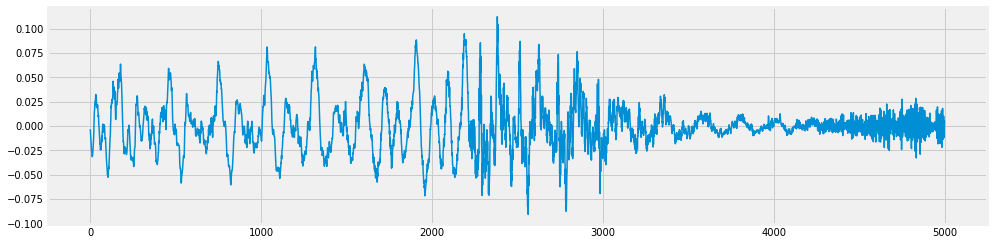

In [2]:
amplitudes, sample_rate = librosa.load("sample_m.wav")
print(f"{len(amplitudes)} points, {len(amplitudes) / sample_rate} sec, sr {sample_rate}")
plt.figure(figsize=[15, 4])
plt.title('')
plt.plot(amplitudes[20000:25000],linewidth=1.5)

In [0]:
def slice_into_frames(amplitudes, window_length, hop_length):
    return librosa.core.spectrum.util.frame(
        np.pad(amplitudes, int(window_length // 2), mode='reflect'),
        frame_length=window_length, hop_length=hop_length)
    # выход: [window_length, num_windows]

In [0]:
def get_STFT(amplitudes, window_length, hop_length):
    """ Compute short-time Fourier Transform """
    # разбиваем амплитуды на пересекающиеся фреймы [window_length, num_frames]
    frames = slice_into_frames(amplitudes, window_length, hop_length)
    
    # получаем веса для Фурье, float[window_length]
    fft_weights = librosa.core.spectrum.get_window('hann', window_length, fftbins=True)
    
    # применяем преобразование Фурье
    stft = np.fft.rfft(frames * fft_weights[:, None], axis=0)
    return stft

In [0]:
def get_melspectrogram(amplitudes, sample_rate=22050, n_mels=128,
                       window_length=2048, hop_length=512, fmin=1, fmax=8192):
    """
    Implement mel-spectrogram as described above.
    :param amplitudes: float [num_amplitudes]
    :param sample rate: число отсчетов каждую секунду
    :param n_mels: число каналов спектрограммы
    :param window_length: параметр размера окна для Фурье
    :param hop_length: размер пересечения 
    :param f_min: мин частота
    :param f_max: макс частота
    :returns: мел-scaled спектрограмма [n_mels, duration]
    """
    # Шаг 1
    stft = get_STFT(amplitudes, window_length, hop_length)
    assert stft.shape == (window_length // 2 + 1, len(amplitudes) // 512 + 1)
    
    # Шаг 2
    spectrogram = np.abs(stft ** 2)
    
    # Шаг 3
    mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,
                                    n_mels=n_mels, fmin=fmin, fmax=fmax)
    # ^-- matrix [n_mels, window_length / 2 + 1]
    
    mel_spectrogram = np.dot(mel_basis, spectrogram)
    assert mel_spectrogram.shape == (n_mels, len(amplitudes) // 512 + 1)
    
    return mel_spectrogram

In [0]:
amplitudes1, _  = librosa.load('sample_m.wav')
amplitudes2, _  = librosa.load('sample_f.wav')

In [0]:
ref1 = librosa.feature.melspectrogram(amplitudes2, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)
assert np.allclose(get_melspectrogram(amplitudes2), ref1, rtol=1e-4, atol=1e-4)

In [12]:
!wget https://ndownloader.figshare.com/files/10256148

--2020-05-17 23:23:57--  https://ndownloader.figshare.com/files/10256148
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 52.49.29.191, 52.18.162.161, 34.252.167.52, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|52.49.29.191|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148/TIMIT.zip [following]
--2020-05-17 23:23:57--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148/TIMIT.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.108.187
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.108.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 440207227 (420M) [binary/octet-stream]
Saving to: ‘10256148.4’

10256148.4          100%[===================>] 419.81M  95.0MB/s    in 4.3s    

2020-05-17 23:24:01 (97.0 MB/s) - ‘10256148.4’ saved [440207227/440207227]



In [0]:
!unzip -q 10256148

replace data/lisa/data/timit/raw/TIMIT/DOC/PROMPTS.TXT? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
!pip install timit-utils

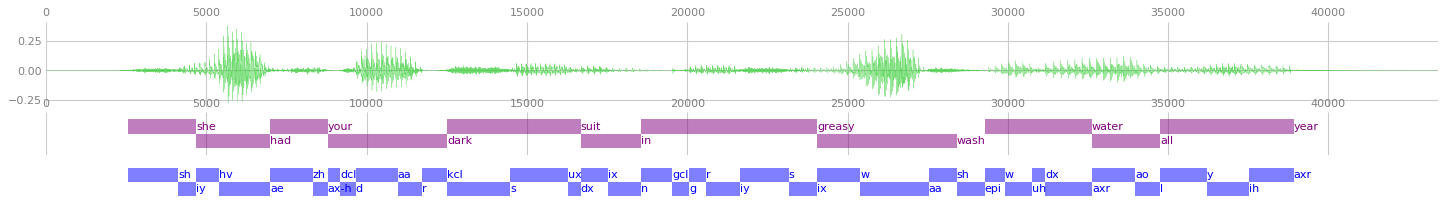

In [8]:
%matplotlib inline
import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du

DATA_PATH = 'data/lisa/data/timit/raw/TIMIT'
corpus = tu.Corpus(DATA_PATH)
sentence = corpus.train.sentences_by_phone_df('aa').sentence[0]
du.DrawVerticalPanels([du.AudioPanel(sentence.raw_audio, show_x_axis=True),
                       du.WordsPanel(sentence.words_df, sentence.raw_audio.shape[0], show_x_axis=True),
                       du.PhonesPanel(sentence.phones_df, sentence.raw_audio.shape[0])
                      ])
  

In [0]:
class Speaker:

  def __init__(self, data_path):
    self.doc_file_path = os.path.join(data_path, 'DOC','SPKRINFO.TXT')
    with open(self.doc_file_path) as f:
      self.id_sex_dict = dict([(tmp.split(' ')[0], tmp.split(' ')[2]) for tmp in f.readlines()[39:]])

  def return_sex(self, id):
    return self.id_sex_dict[id]

Speakers_info = Speaker(DATA_PATH)

In [0]:
person_1 = corpus.train.person_by_index(100)

In [0]:
def preprocess_sample(amplitudes, gender, sr=16000, max_length=150):
    spectrogram = get_melspectrogram(amplitudes, sample_rate=sr)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
    target = 0 if gender == 'F' else 1
    return np.float32(spectrogram), np.int64(target)
    
tmp_1 = preprocess_sample(person_1.sentence_by_index(1).raw_audio, Speakers_info.return_sex(person_1.name))[0]
tmp_2 = librosa.feature.melspectrogram(person_1.sentence_by_index(1).raw_audio, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)
assert np.allclose(get_melspectrogram(amplitudes2), ref1, rtol=1e-4, atol=1e-4)

In [0]:
def create_dataset(mode='train'):
  assert mode in ['train','test']
  if mode == 'train':
    people = [corpus.train.person_by_index(i) for i in range(400)]
  if mode == 'test':
    people = [corpus.test.person_by_index(i) for i in range(150)]
  spectrograms_and_targets = []
  for person in tqdm_notebook(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      spectrograms_and_targets.append(preprocess_sample(person.sentence_by_index(i).raw_audio, target))
  return spectrograms_and_targets

In [13]:
trainset = create_dataset('train')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
X, y = map(np.stack, zip(*trainset))
X = X.transpose([0, 2, 1])  # to [batch, time, channels]

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [15]:
import keras, keras.layers

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(None, 128)), 
    keras.layers.Conv1D(32, kernel_size=4), keras.layers.Activation('relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=4), keras.layers.Activation('relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=4), keras.layers.Activation('relu'),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          16416     
_________________________________________________________________
activation_1 (Activation)    (None, None, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 32)          128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          8256      
_________________________________________________________________
activation_2 (Activation)    (None, None, 64)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 64)          256       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)        

In [16]:
model.compile('adam', 'sparse_categorical_crossentropy',
          metrics = ['sparse_categorical_accuracy'])
model.fit(X_train, y_train, epochs=20, validation_data = [X_val, y_val]) 

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 5s 2ms/step - loss: 0.2574 - sparse_categorical_accuracy: 0.8940 - val_loss: 0.3327 - val_sparse_categorical_accuracy: 0.8920
Epoch 2/20
3000/3000 [==============================] - 5s 2ms/step - loss: 0.0753 - sparse_categorical_accuracy: 0.9777 - val_loss: 0.5925 - val_sparse_categorical_accuracy: 0.7180
Epoch 3/20
3000/3000 [==============================] - 5s 2ms/step - loss: 0.0358 - sparse_categorical_accuracy: 0.9903 - val_loss: 0.2344 - val_sparse_categorical_accuracy: 0.8770
Epoch 4/20
3000/3000 [==============================] - 5s 2ms/step - loss: 0.0334 - sparse_categorical_accuracy: 0.9880 - val_loss: 0.0491 - val_sparse_categorical_accuracy: 0.9860
Epoch 5/20
3000/3000 [==============================] - 5s 2ms/step - loss: 0.0344 - sparse_categorical_accuracy: 0.9893 - val_loss: 0.0405 - val_sparse_categorical_accuracy: 0.9860
Epoch 6/20
3000/3000 [====================

In [17]:
testset = create_dataset('test')
X_test, y_test = map(np.stack, zip(*testset))
X_test = X_test.transpose([0, 2, 1])  # to [batch, time, channels]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [18]:
len(X_test)

1500

In [0]:
y_pred = model.predict_classes(X_test)

In [20]:
accuracy_score(y_pred, y_test)

0.9886666666666667

In [0]:
def spoil_with_noise(data, noise_factor=0.02,sampling_rate=16000,pitch_factor=0.9,speed_factor=0.5):
    noise = np.random.normal(size=len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    augmented_data = librosa.effects.time_stretch(augmented_data, speed_factor)
    augmented_data = librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
    return augmented_data

In [0]:
test_wav = person_1.sentence_by_index(0).raw_audio

In [23]:
IPython.display.Audio(spoil_with_noise(person_1.sentence_by_index(0).raw_audio), rate=16000)

In [0]:
def spoil_dataset(mode='train'):
  assert mode in ['train','test']
  if mode == 'train':
    people = [corpus.train.person_by_index(i) for i in range(400)]
  if mode == 'test':
    people = [corpus.test.person_by_index(i) for i in range(150)]
  spectrograms_and_targets = []
  for person in tqdm_notebook(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      spectrograms_and_targets.append(preprocess_sample(spoil_with_noise(person.sentence_by_index(i).raw_audio),target))
  return spectrograms_and_targets

In [25]:
testset = spoil_dataset('test')
X_test, y_test = map(np.stack, zip(*testset))
X_test = X_test.transpose([0, 2, 1])  # to [batch, time, channels]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [26]:
accuracy_score(model.predict_classes(X_test),y_test)

0.926

In [27]:
X_val.shape

(1000, 150, 128)

In [28]:
trainset1 = create_dataset('train')
X1, y1 = map(np.stack, zip(*trainset1))
X1 = X1.transpose([0, 2, 1])  # to [batch, time, channels]

X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, random_state=42)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [29]:
import keras, keras.layers

model1 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(None, 128)), 
    keras.layers.Conv1D(32, kernel_size=4), keras.layers.Activation('relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=4), keras.layers.Activation('relu'),
    keras.layers.Conv1D(128, kernel_size=4), keras.layers.Activation('relu'),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(2, activation='softmax')
])
model1.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, None, 32)          16416     
_________________________________________________________________
activation_4 (Activation)    (None, None, 32)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 32)          128       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          8256      
_________________________________________________________________
activation_5 (Activation)    (None, None, 64)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 128)         32896     
_________________________________________________________________
activation_6 (Activation)    (None, None, 128)        

In [30]:
model1.compile('adam', 'sparse_categorical_crossentropy',
          metrics = ['sparse_categorical_accuracy'])
model1.fit(X_train1, y_train1, epochs=5, validation_data = [X_val1, y_val1]) 

Train on 3000 samples, validate on 1000 samples
Epoch 1/5
3000/3000 [==============================] - 4s 1ms/step - loss: 0.4186 - sparse_categorical_accuracy: 0.8067 - val_loss: 0.3926 - val_sparse_categorical_accuracy: 0.8770
Epoch 2/5
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1398 - sparse_categorical_accuracy: 0.9603 - val_loss: 0.1892 - val_sparse_categorical_accuracy: 0.9500
Epoch 3/5
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0758 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.1020 - val_sparse_categorical_accuracy: 0.9760
Epoch 4/5
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0507 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.0775 - val_sparse_categorical_accuracy: 0.9820
Epoch 5/5
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0341 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.0579 - val_sparse_categorical_accuracy: 0.9890


In [31]:
y_pred = model.predict_classes(X_test)
accuracy_score(y_pred, y_test)

0.926